In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as spst
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report,mean_absolute_percentage_error
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.impute import KNNImputer
from workalendar.asia import SouthKorea
cal = SouthKorea()
from catboost import CatBoostRegressor

In [40]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
building_info = pd.read_csv("building_info.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [41]:
data.loc[data['건물번호']==1]

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20220601 00,1,20220601 00,18.6,NaN,0.9,42.0,NaN,NaN,1085.28
1,1_20220601 01,1,20220601 01,18.0,NaN,1.1,45.0,NaN,NaN,1047.36
2,1_20220601 02,1,20220601 02,17.7,NaN,1.5,45.0,NaN,NaN,974.88
3,1_20220601 03,1,20220601 03,16.7,NaN,1.4,48.0,NaN,NaN,953.76
4,1_20220601 04,1,20220601 04,18.4,NaN,2.8,43.0,NaN,NaN,986.40
...,...,...,...,...,...,...,...,...,...,...
2035,1_20220824 19,1,20220824 19,25.5,NaN,2.9,63.0,0.1,0.19,2517.12
2036,1_20220824 20,1,20220824 20,25.0,NaN,2.6,66.0,0.0,0.01,2208.96
2037,1_20220824 21,1,20220824 21,24.6,NaN,1.3,67.0,NaN,NaN,1806.24
2038,1_20220824 22,1,20220824 22,24.1,NaN,2.1,70.0,NaN,NaN,1387.20


In [52]:
def gggg(test,building_info):
    test = test.drop(["num_date_time",'일조(hr)','일사(MJ/m2)'],axis=1)
    test["강수량(mm)"] = test["강수량(mm)"].fillna(0)
    
    imputer = KNNImputer(n_neighbors=5)
    imputer2 = KNNImputer(n_neighbors=5)    
    test[["풍속(m/s)"]] = imputer.fit_transform(test[["풍속(m/s)"]])
    test[["습도(%)"]] = imputer2.fit_transform(test[["습도(%)"]])
    
    test = pd.merge(test, building_info, how = 'inner', on = '건물번호')
    test = test.drop(['건물번호','건물유형'],axis=1)
    
    test['일시1'] = pd.to_datetime(test['일시'])
    test['month'] = test["일시1"].dt.month
    test['day'] = test["일시1"].dt.day
    test['hour'] = test["일시1"].dt.hour
    test['강수 유무'] = np.where(test["강수량(mm)"]==0,0,1)
    test["불쾌지수"] = 9/5*test["기온(C)"]-0.55*(1-(test["습도(%)"]/100))*(9/5*test["기온(C)"]-26)+32
    
    test['측정일시2'] = pd.to_datetime(test['일시1']).dt.date
    test['측정일시2'] = pd.to_datetime(test['측정일시2'])
    test['day_of_week'] = test['측정일시2'].dt.day_name()  # 요일
    test = test.rename(columns={'측정일시2':'Date'})
    holiday=pd.DataFrame(cal.holidays(2022))
    holiday=holiday.rename(columns={0:"Date",1:"holiday"})
    holiday["Date"] = pd.to_datetime(holiday["Date"])
    test = pd.merge(test,holiday,on="Date",how="left")
    test['빨간날'] = np.where((test['day_of_week']=='Sunday') | (test['day_of_week']=='Saturday') | (test['holiday'].isnull()==False),1,0)
    
    test = test.drop(['holiday','day_of_week','Date','일시1','일시'],axis=1)
    
    


    test['불쾌지수 단계'] = pd.cut(test['불쾌지수'], bins =[0,68, 75, 80,100] , labels = [0,1,2,3])
    test = pd.get_dummies(test, columns = ['불쾌지수 단계'],drop_first=True)
    test = test.drop(['연면적(m2)','냉방면적(m2)'],axis=1)
    
    test = test.drop(["태양광용량(kW)","ESS저장용량(kWh)","PCS용량(kW)"],axis=1)

    return test

def test123(test,building_info):
    test = test.drop(["num_date_time"],axis=1)
    test["강수량(mm)"] = test["강수량(mm)"].fillna(0)
    
    imputer = KNNImputer(n_neighbors=5)
    imputer2 = KNNImputer(n_neighbors=5)    
    test[["풍속(m/s)"]] = imputer.fit_transform(test[["풍속(m/s)"]])
    test[["습도(%)"]] = imputer2.fit_transform(test[["습도(%)"]])
    
    test = pd.merge(test, building_info, how = 'inner', on = '건물번호')
    test = test.drop(['건물번호','건물유형'],axis=1)
    
    test['일시1'] = pd.to_datetime(test['일시'])
    test['month'] = test["일시1"].dt.month
    test['day'] = test["일시1"].dt.day
    test['hour'] = test["일시1"].dt.hour
    test['강수 유무'] = np.where(test["강수량(mm)"]==0,0,1)
    test["불쾌지수"] = 9/5*test["기온(C)"]-0.55*(1-(test["습도(%)"]/100))*(9/5*test["기온(C)"]-26)+32
    
    test['측정일시2'] = pd.to_datetime(test['일시1']).dt.date
    test['측정일시2'] = pd.to_datetime(test['측정일시2'])
    test['day_of_week'] = test['측정일시2'].dt.day_name()  # 요일
    test = test.rename(columns={'측정일시2':'Date'})
    holiday=pd.DataFrame(cal.holidays(2022))
    holiday=holiday.rename(columns={0:"Date",1:"holiday"})
    holiday["Date"] = pd.to_datetime(holiday["Date"])
    test = pd.merge(test,holiday,on="Date",how="left")
    test['빨간날'] = np.where((test['day_of_week']=='Sunday') | (test['day_of_week']=='Saturday') | (test['holiday'].isnull()==False),1,0)
    
    test = test.drop(['holiday','day_of_week','Date','일시1','일시'],axis=1)
    
    
    test['불쾌지수 단계'] = pd.cut(test['불쾌지수'], bins =[0,68, 75, 80,100] , labels = [0,1,2,3])
    test = pd.get_dummies(test, columns = ['불쾌지수 단계'],drop_first=True)
    test = test.drop(['연면적(m2)','냉방면적(m2)'],axis=1)
    
    test = test.drop(["태양광용량(kW)","ESS저장용량(kWh)","PCS용량(kW)"],axis=1)

    return test

def result(sample_submission,y_pred):
    sample_submission['answer1'] = y_pred
    sample_submission = sample_submission.drop('answer',axis=1)
    sample_submission = sample_submission.rename(columns={'answer1':'answer'})
    sample_submission.to_csv('cat2.csv',index = False)

In [43]:
train1 = gggg(data.loc[data['건물번호']==1],building_info)
train1

,기온(C),강수량(mm),풍속(m/s),습도(%),전력소비량(kWh),month,day,hour,강수 유무,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,18.6,0.0,0.9,42.0,1085.28,6,1,0,0,63.09388,0,0,0,0
1,18.0,0.0,1.1,45.0,1047.36,6,1,1,0,62.46400,0,0,0,0
2,17.7,0.0,1.5,45.0,974.88,6,1,2,0,62.08735,0,0,0,0
3,16.7,0.0,1.4,48.0,953.76,6,1,3,0,60.89884,0,0,0,0
4,18.4,0.0,2.8,43.0,986.40,6,1,4,0,62.88788,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,25.5,0.0,2.9,63.0,2517.12,8,24,19,0,73.85035,0,1,0,0
2036,25.0,0.0,2.6,66.0,2208.96,8,24,20,0,73.44700,0,1,0,0
2037,24.6,0.0,1.3,67.0,1806.24,8,24,21,0,72.96218,0,1,0,0
2038,24.1,0.0,2.1,70.0,1387.20,8,24,22,0,72.51230,0,1,0,0


In [44]:
test1 = test123(test.loc[test['건물번호']==1],building_info)
test1

,기온(C),강수량(mm),풍속(m/s),습도(%),month,day,hour,강수 유무,불쾌지수,빨간날,불쾌지수 단계_1,불쾌지수 단계_2,불쾌지수 단계_3
0,23.5,0.0,2.2,72.0,8,25,0,0,71.78980,0,1,0,0
1,23.0,0.0,0.9,72.0,8,25,1,0,71.02840,0,1,0,0
2,22.7,0.0,1.5,75.0,8,25,2,0,70.81675,0,1,0,0
3,22.1,0.0,1.3,78.0,8,25,3,0,70.11262,0,1,0,0
4,21.8,0.0,1.0,77.0,8,25,4,0,69.56514,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,23.5,0.0,2.0,75.0,8,31,19,0,72.05875,0,1,0,0
164,22.4,0.0,2.0,80.0,8,31,20,0,70.74480,0,1,0,0
165,21.7,0.0,1.6,81.0,8,31,21,0,69.69523,0,1,0,0
166,21.1,0.0,1.0,83.0,8,31,22,0,68.85987,0,1,0,0


In [45]:
x=train1.drop('전력소비량(kWh)',axis=1)
y=train1[['전력소비량(kWh)']]

sc = StandardScaler()
sc1 = StandardScaler()
sc.fit(x)
x = sc.transform(x)
x = pd.DataFrame(x,columns=train1.drop('전력소비량(kWh)',axis=1).columns)
sc1.fit(test1)
test1 = sc1.transform(test1)
test1 = pd.DataFrame(test1,columns=train1.drop('전력소비량(kWh)',axis=1).columns)

In [46]:
model = CatBoostRegressor(random_state=42)
model.fit(x,y)

Learning rate set to 0.045825
0:	learn: 1075.2483798	total: 1.5ms	remaining: 1.49s
1:	learn: 1036.3657350	total: 2.9ms	remaining: 1.44s
2:	learn: 1002.6929015	total: 4.31ms	remaining: 1.43s
3:	learn: 967.4867435	total: 5.63ms	remaining: 1.4s
4:	learn: 934.5753137	total: 7.09ms	remaining: 1.41s
5:	learn: 904.4269717	total: 8.29ms	remaining: 1.37s
6:	learn: 873.0350775	total: 9.75ms	remaining: 1.38s
7:	learn: 843.5286874	total: 10.9ms	remaining: 1.35s
8:	learn: 816.6615719	total: 12.1ms	remaining: 1.33s
9:	learn: 792.8777599	total: 13.3ms	remaining: 1.32s
10:	learn: 768.4419291	total: 14.9ms	remaining: 1.34s
11:	learn: 746.1836543	total: 16.3ms	remaining: 1.34s
12:	learn: 720.5372783	total: 17.4ms	remaining: 1.32s
13:	learn: 698.4415198	total: 18.6ms	remaining: 1.31s
14:	learn: 677.3357268	total: 19.9ms	remaining: 1.31s
15:	learn: 658.9452271	total: 21.2ms	remaining: 1.3s
16:	learn: 640.9464094	total: 22.8ms	remaining: 1.32s
17:	learn: 620.2856346	total: 24.4ms	remaining: 1.33s
18:	learn

,feature_name,feature_importance
0,hour,75.543347
1,month,6.457682
2,불쾌지수,4.780912
3,빨간날,4.127521
4,day,3.671393
5,기온(C),1.750997
6,습도(%),1.482514
7,풍속(m/s),0.827469
8,불쾌지수 단계_2,0.683419
9,강수량(mm),0.258743


C:\Users\dufwn\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48520 (\N{HANGUL SYLLABLE BUL}) missing from current font.
  func(*args, **kwargs)
C:\Users\dufwn\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 53132 (\N{HANGUL SYLLABLE KWAE}) missing from current font.
  func(*args, **kwargs)
C:\Users\dufwn\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  func(*args, **kwargs)
C:\Users\dufwn\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  func(*args, **kwargs)
C:\Users\dufwn\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Glyph 48744 (\N{HANGUL SYLLABLE BBAL}) missing from current font.
  func(*args, **kwargs)
C:\Users\dufwn\AppData\Roaming\Python\Python3

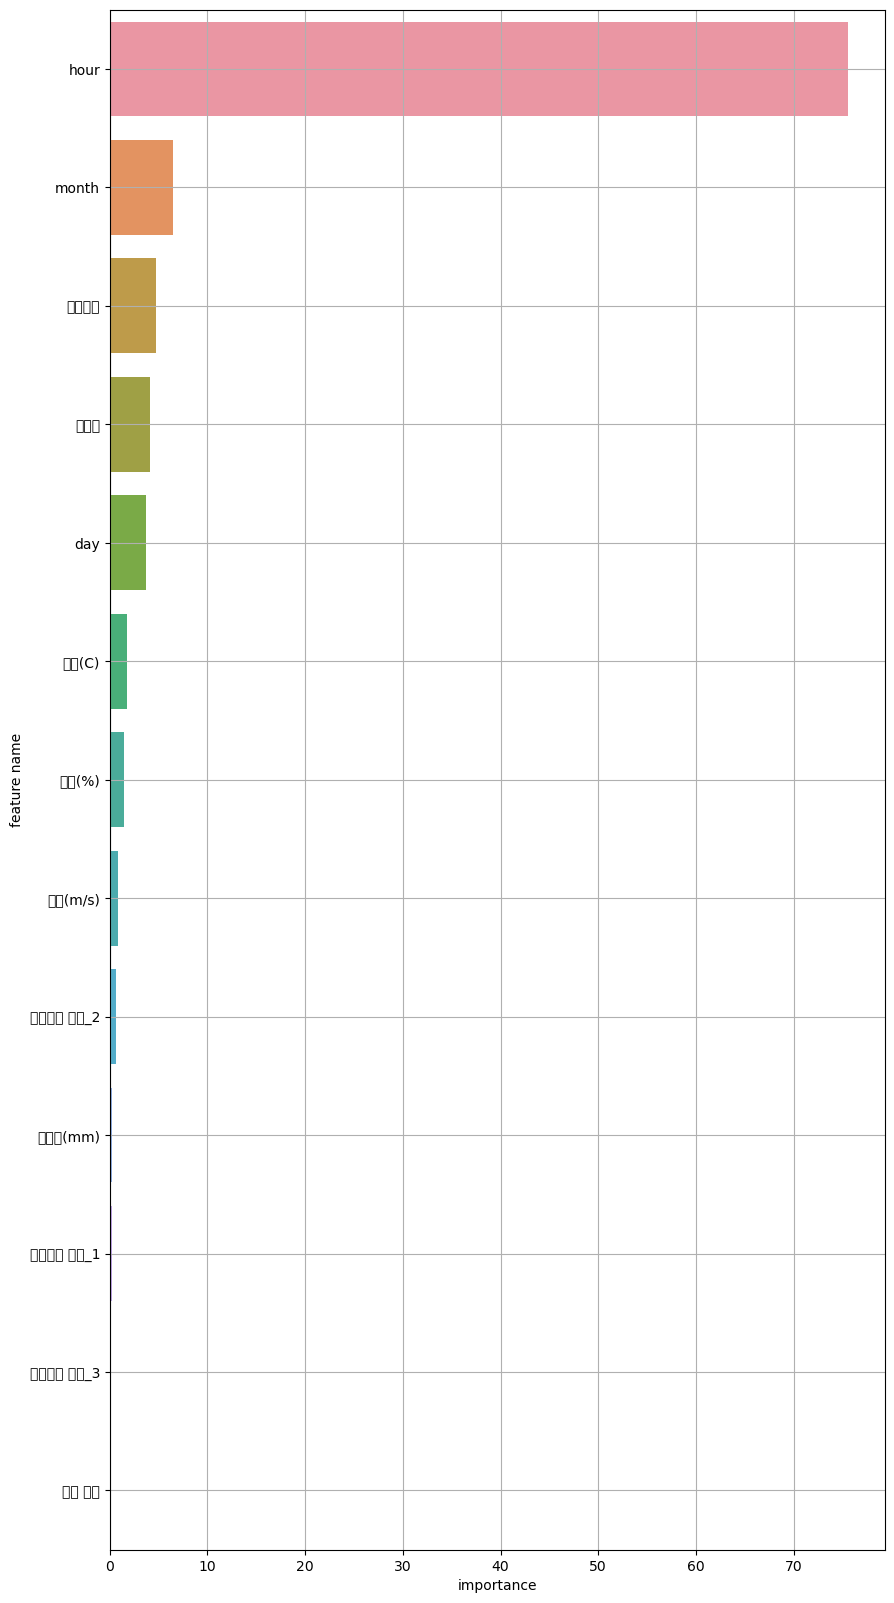

In [47]:
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

plot_feature_importance(model.feature_importances_,x.columns,result_only = False)

In [48]:
y_pred = model.predict(test1)
y_pred

array([1855.61815618, 1668.31032904, 1628.81743474, 1465.89205471,
       1472.04343799, 1733.13886427, 2052.93918193, 2315.90737971,
       2932.6484759 , 3601.36569643, 4070.08444773, 4580.91226584,
       4590.11528125, 4438.91851473, 4313.47265218, 4016.84788645,
       4033.4501529 , 3603.07776403, 2926.50494351, 2686.1968323 ,
       2465.76046449, 2061.92102924, 1597.25365461, 1975.66284835,
       2076.12103633, 1998.88466977, 1890.54101221, 1741.74747811,
       1771.84558002, 1711.78623564, 2007.05142306, 2462.20491178,
       3047.83037276, 3574.40321331, 4603.64774075, 4684.36798292,
       4749.77463443, 4694.03284589, 4639.82196002, 4381.0377428 ,
       4304.61893275, 3902.73267362, 3248.56996852, 3096.58941573,
       2660.43617134, 2172.93000344, 1539.43665936, 2107.27224782,
       1998.49834681, 1948.53246873, 1810.13851525, 1657.03661749,
       1559.43073978, 1510.1097496 , 1752.69985996, 1977.83253139,
       2350.2995065 , 2633.93409535, 3199.20449161, 3347.74654

In [49]:
a = y_pred
a_ = list(a)

In [50]:
def ma(data,test):
    for i in range(2,101):
        train1 = gggg(data.loc[data['건물번호']==i],building_info)
        test1 = test123(test.loc[test['건물번호']==i],building_info)

        x=train1.drop('전력소비량(kWh)',axis=1)
        y=train1[['전력소비량(kWh)']]

        sc = StandardScaler()
        sc1 = StandardScaler()
        sc.fit(x)
        x = sc.transform(x)
        x = pd.DataFrame(x,columns=train1.drop('전력소비량(kWh)',axis=1).columns)
        sc1.fit(test1)
        test1 = sc1.transform(test1)
        test1 = pd.DataFrame(test1,columns=train1.drop('전력소비량(kWh)',axis=1).columns)

        model = CatBoostRegressor(random_state=42,verbose=0)
        model.fit(x,y)
        y_pred = model.predict(test1)
        b = y_pred
        for j in b:
            a_.append(j)

In [51]:
ma(data,test)

In [53]:

result(sample_submission,a_)

In [54]:
############################################

In [256]:
# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
train1 = gggg(data.loc[data['건물번호']==1],building_info)
test1 = test123(test.loc[test['건물번호']==1],building_info)
x=train1.drop('전력소비량(kWh)',axis=1)
y=train1[['전력소비량(kWh)']]

print(len(x))

sc = StandardScaler()
sc1 = StandardScaler()
sc.fit(x)
x = sc.transform(x)
x = pd.DataFrame(x,columns=train1.drop('전력소비량(kWh)',axis=1).columns)
sc1.fit(test1)
test1 = sc1.transform(test1)



timestep= 1 #한번에 21주씩 고려하기 (batch?)

# x의 데이터 구조를 3차원으로 만들어줘야 합니다.
# x = np.array([x[i : i + timestep] for i in range( len(x) - timestep ) ])
# y = np.array([y[i : i + timestep] for i in range( len(y) - timestep ) ])

# print(x)
# print(y)

x_train, x_val = x[:1608], x[1608:]
y_train, y_val = y[:1608], y[1608:]

x_train = np.expand_dims(x_train, axis=1)
x_val = np.expand_dims(x_val, axis=1)
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)



print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
# print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')

2040
(2040, 13) (2040, 1)
-------------------------------
(1608, 1, 13) (1608, 1)
(432, 1, 13) (432, 1)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


In [257]:
x_train

array([[[-2.01292096, -0.20546421, -1.27289857, ..., -0.6401667 ,
         -0.85542313, -0.48540167]],

       [[-2.18097444, -0.20546421, -1.09416006, ..., -0.6401667 ,
         -0.85542313, -0.48540167]],

       [[-2.26500118, -0.20546421, -0.73668304, ..., -0.6401667 ,
         -0.85542313, -0.48540167]],

       ...,

       [[ 0.90000601, -0.20546421, -1.45163708, ..., -0.6401667 ,
         -0.85542313,  2.06014949]],

       [[ 0.84398819, -0.20546421, -0.46857527, ..., -0.6401667 ,
         -0.85542313,  2.06014949]],

       [[ 0.75996145, -0.20546421, -0.91542155, ..., -0.6401667 ,
         -0.85542313,  2.06014949]]])

In [258]:
keras.backend.clear_session()

il = keras.layers.Input(shape=(1,13))
ll = keras.layers.LSTM(16, return_sequences=True)(il)
ll = keras.layers.BatchNormalization()(ll)
ol = keras.layers.Dense(1)(ll)

model = keras.models.Model(il,ol)
model.compile(loss=keras.losses.mean_absolute_percentage_error,metrics=['mse'],optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 13)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             1920      
                                                                 
 batch_normalization (BatchN  (None, 1, 16)            64        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1, 1)              17        
                                                                 
Total params: 2,001
Trainable params: 1,969
Non-trainable params: 32
_________________________________________________________________


In [259]:
es = EarlyStopping(monitor="val_loss",
                   min_delta=0.001,
                   verbose=1,
                   patience = 10,
                   restore_best_weights = True)
rl = ReduceLROnPlateau(monitor="val_loss",
                       patience=4,
                       factor=0.15,
                       verbose=1,
                       min_lr=0.0000001)
history = model.fit(x_train,y_train,callbacks=[es,rl],epochs=200,verbose=1,validation_data=[x_val,y_val])

Epoch 1/200
51/51 [==============================] - 2s 10ms/step - loss: 99.9762 - mse: 7977484.5000 - val_loss: 99.9938 - val_mse: 9395552.0000 - lr: 0.0010
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 99.9286 - mse: 7978486.5000 - val_loss: 99.9844 - val_mse: 9395031.0000 - lr: 0.0010
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 99.8736 - mse: 7978826.5000 - val_loss: 99.9728 - val_mse: 9394594.0000 - lr: 0.0010
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 99.8054 - mse: 7978617.5000 - val_loss: 99.9585 - val_mse: 9394452.0000 - lr: 0.0010
Epoch 5/200
51/51 [==============================] - 0s 2ms/step - loss: 99.7245 - mse: 7977525.5000 - val_loss: 99.9381 - val_mse: 9394114.0000 - lr: 0.0010
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 99.6291 - mse: 7975985.0000 - val_loss: 99.9149 - val_mse: 9394225.0000 - lr: 0.0010
Epoch 7/200
51/51 [==============================] 

In [260]:
test1 = np.expand_dims(test1, axis=1)
test1.shape

(168, 1, 13)

In [261]:
y_pred = model.predict(test1)
a = y_pred

6/6 [==============================] - 0s 1ms/step


In [262]:
a

array([[[1810.7008 ]],

       [[1570.5117 ]],

       [[1700.6675 ]],

       [[1624.8408 ]],

       [[1565.645  ]],

       [[1814.5234 ]],

       [[2175.7085 ]],

       [[2140.4355 ]],

       [[2613.0273 ]],

       [[2724.5454 ]],

       [[2830.1099 ]],

       [[2731.868  ]],

       [[1778.9937 ]],

       [[1594.2448 ]],

       [[1507.4863 ]],

       [[1873.3462 ]],

       [[2071.3027 ]],

       [[1866.6863 ]],

       [[1785.6064 ]],

       [[1708.6711 ]],

       [[1694.4678 ]],

       [[1692.973  ]],

       [[1593.1486 ]],

       [[1688.8292 ]],

       [[1554.2585 ]],

       [[1655.7573 ]],

       [[1712.8562 ]],

       [[1417.0732 ]],

       [[1546.8354 ]],

       [[1516.048  ]],

       [[1559.7295 ]],

       [[1829.1924 ]],

       [[2523.1719 ]],

       [[2688.226  ]],

       [[2702.8494 ]],

       [[2750.5322 ]],

       [[2580.2192 ]],

       [[2511.8213 ]],

       [[2393.8188 ]],

       [[2362.288  ]],

       [[2328.1357 ]],

       [[2255.85

In [277]:
a__=[]
for i in a:
    a__.append(i[0][0])

In [278]:
def maa(data,test):
    for i in range(2,101):
        train1 = gggg(data.loc[data['건물번호']==i],building_info)
        test1 = test123(test.loc[test['건물번호']==i],building_info)

        x=train1.drop('전력소비량(kWh)',axis=1)
        y=train1[['전력소비량(kWh)']]

                
        firstb = x[["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3']]
        x_ = x.drop(["불쾌지수 단계_1", '불쾌지수 단계_2', '불쾌지수 단계_3'],axis=1)

        scaler = StandardScaler()
        scaler.fit(x_)
        x_train = scaler.transform(x_) 

        x_train = pd.DataFrame(x_train,index=x_.index,columns=x_.columns)
        x = pd.concat([x_train,firstb],axis=1)
        x = np.expand_dims(x, axis=1)

        sc1 = StandardScaler()
        sc1.fit(test1)
        test1 = sc1.transform(test1)
        test1 = np.expand_dims(test1, axis=1)
            
        keras.backend.clear_session()

        il = keras.layers.Input(shape=(1,13))
        ll = keras.layers.LSTM(16, return_sequences=True)(il)
        ll = keras.layers.BatchNormalization()(ll)
        ol = keras.layers.Dense(1)(ll)

        model = keras.models.Model(il,ol)
        model.compile(loss=keras.losses.mean_absolute_percentage_error,metrics=['mape'],optimizer='adam')

        model.fit(x,y,epochs=200,verbose=0)

        y_pred = model.predict(test1)
        for j in y_pred:
            a__.append(j[0][0])


In [279]:
maa(data,test)
result(sample_submission,a__)

6/6 [==============================] - 0s 2ms/step


In [276]:
a__

[1810.7008,
 1570.5117,
 1700.6675,
 1624.8408,
 1565.645,
 1814.5234,
 2175.7085,
 2140.4355,
 2613.0273,
 2724.5454,
 2830.1099,
 2731.868,
 1778.9937,
 1594.2448,
 1507.4863,
 1873.3462,
 2071.3027,
 1866.6863,
 1785.6064,
 1708.6711,
 1694.4678,
 1692.973,
 1593.1486,
 1688.8292,
 1554.2585,
 1655.7573,
 1712.8562,
 1417.0732,
 1546.8354,
 1516.048,
 1559.7295,
 1829.1924,
 2523.1719,
 2688.226,
 2702.8494,
 2750.5322,
 2580.2192,
 2511.8213,
 2393.8188,
 2362.288,
 2328.1357,
 2255.8582,
 1957.1766,
 1859.4738,
 1799.1312,
 1786.5586,
 1790.0842,
 1786.7888,
 1588.638,
 1612.5818,
 1201.2664,
 1448.0425,
 1306.3826,
 1060.2935,
 1161.7654,
 1259.2136,
 1408.9019,
 1702.8601,
 2211.9575,
 2339.455,
 2519.624,
 2524.325,
 2514.0354,
 2406.2036,
 2217.7212,
 2033.2708,
 1854.0623,
 1643.8638,
 1421.5806,
 1587.2168,
 1568.5974,
 1581.4419,
 1063.526,
 959.11615,
 949.0222,
 974.0993,
 974.7344,
 1016.10004,
 1083.6823,
 1221.4592,
 1469.8647,
 1972.5809,
 2427.9424,
 2767.6846,
 2938

In [281]:
cat1 = pd.read_csv("cat1.csv")
cat2 = pd.read_csv("cat2.csv")
cat3 = pd.read_csv("cat3.csv")
cat4 = pd.read_csv("cat4.csv")

sample_submission['answer'] = (cat1['answer']+cat2['answer']+cat3['answer']+cat4['answer'])/4
sample_submission

,num_date_time,answer,answer1
0,1_20220825 00,1885.373415,1810.700806
1,1_20220825 01,1776.126837,1570.511719
2,1_20220825 02,1739.488616,1700.667480
3,1_20220825 03,1653.542241,1624.840820
4,1_20220825 04,1628.288883,1565.645020
...,...,...,...
16795,100_20220831 19,997.257857,1045.800659
16796,100_20220831 20,893.429198,911.319153
16797,100_20220831 21,806.570073,809.313049
16798,100_20220831 22,712.514680,710.036438


In [283]:
sample_submission = sample_submission.drop(['answer','answer1'],axis=1)
sample_submission

,num_date_time
0,1_20220825 00
1,1_20220825 01
2,1_20220825 02
3,1_20220825 03
4,1_20220825 04
...,...
16795,100_20220831 19
16796,100_20220831 20
16797,100_20220831 21
16798,100_20220831 22


In [284]:
sample_submission['answer'] = (cat1['answer']+cat2['answer']+cat3['answer']+cat4['answer'])/4
sample_submission

,num_date_time,answer
0,1_20220825 00,1885.373415
1,1_20220825 01,1776.126837
2,1_20220825 02,1739.488616
3,1_20220825 03,1653.542241
4,1_20220825 04,1628.288883
...,...,...
16795,100_20220831 19,997.257857
16796,100_20220831 20,893.429198
16797,100_20220831 21,806.570073
16798,100_20220831 22,712.514680


In [285]:
sample_submission.to_csv('cat5.csv',index = False)